In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost import XGBClassifier
import shap
from xgboost import plot_importance
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

In [2]:
#load_data
df=pd.read_csv("Loan_default.csv")

In [3]:
#sampple_data_top_2 rows
df.head(2)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0


In [4]:
#Feature_engineering
df['loan_to_income']=df['LoanAmount']/df['Income']

In [5]:
# describe_data_whether_there_is_null_data
print(df.info(verbose=True))
print(df.describe())
print(df['Default'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [6]:
# filling_missing_values
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0],inplace=True)
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(),inplace=True)

In [7]:
# Caregorical_encoding
categorical=['Education','EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

In [8]:
#Encode_categorical_value_to_numeric
le=LabelEncoder()
for col in categorical:
    df[col]=le.fit_transform(df[col])

In [9]:
# drop_irrelevant_columns
df=df.drop(columns="LoanID")

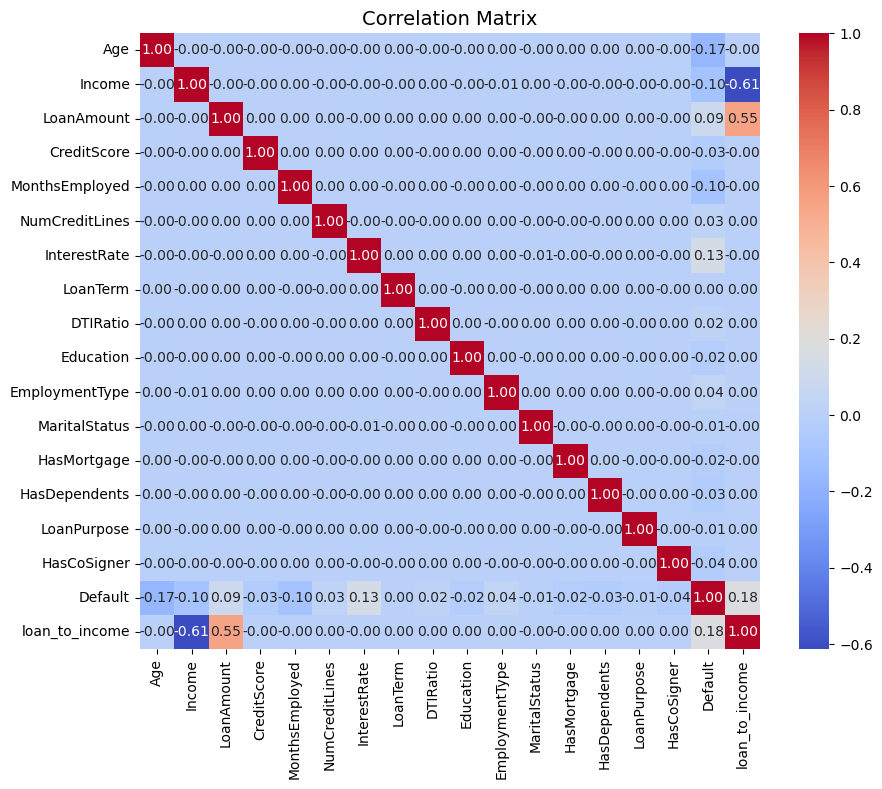

In [10]:
# check correlation
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix", fontsize=14)
plt.show()

In [11]:
#prepare_features_&_target
X=df.drop(columns={"Default"})
y=df["Default"]

In [12]:
#Split into train_test_sets
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
#train_xgboost_model
model=XGBClassifier(n_estimators=1000,learning_rate=0.1,max_depth=4)

In [14]:
model.fit(X_train,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
#predict_probablity_using_model
y_pred=model.predict(X_val)

In [16]:
#accuracy_comparison
print("AccuracyScore:",accuracy_score(y_val,y_pred))

AccuracyScore: 0.8874877618954377


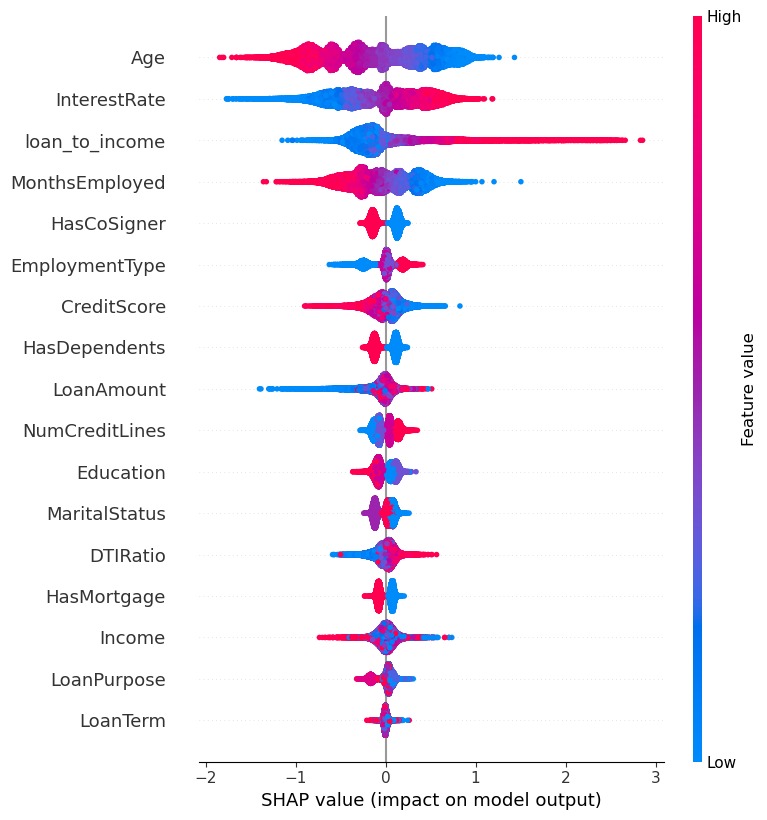

In [17]:
#Shap_feature_importance
explainer=shap.Explainer(model)
shap_values=explainer(X_val)
shap.summary_plot(shap_values,X_val)

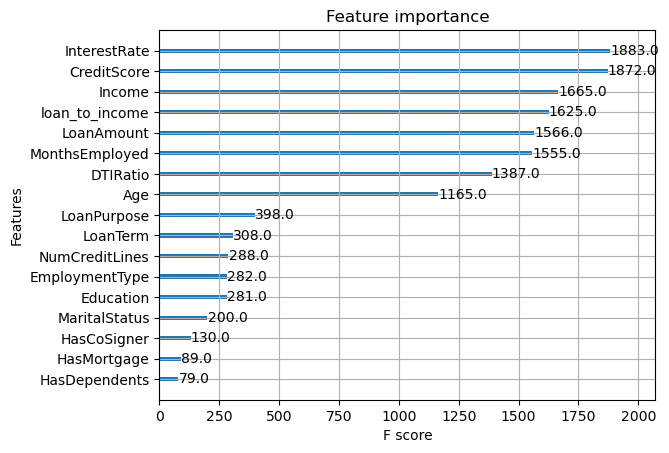

In [18]:
#feature_importance_using_xgboost
plot_importance(model,importance_type='weight')
plt.show()